In [1]:
import sys
from google.colab import drive
drive.mount('/content/drive')
sys.path.append('/content/drive/My Drive/Final_Project_RuiZhou')

sys.path.append("path")

BASEOUTDIR = r'/content/drive/My Drive/Final_Project_RuiZhou'

Mounted at /content/drive


In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from scipy.optimize import fmin_l_bfgs_b
import matplotlib.pyplot as plt
import numpy as np
import os
import decoders
from helpers import initialize_image, gram_matrix, gram_loss, slice_loss

In [3]:
SIZE = 256
INPUT_FILE = "/content/drive/My Drive/Final_Project_RuiZhou/AdditionalTextures/Carpet.jpg"
OUTPUT_FILE = "/content/drive/My Drive/Final_Project_RuiZhou/AdditionalTextures/output.jpg"
NB_ITER = 5

**Custom VGG model with Slicing model**

Here we implement the custom vgg model which will output only specified layers from a pretrained vgg model. We also implement a seperate extractor which performs the slicing in said feature space.

In [4]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # A customized vgg is used as explained in the supplementals.
  vgg = keras.models.load_model('/content/drive/My Drive/Final_Project_RuiZhou/vgg_customized.h5')
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model

"""The loss function is implemented in class Slicing(...) and is used by ExtractorVggModel which directly returns loss """
class Slicing(tf.keras.layers.Layer):
    """ Slicing layer: computes projections and returns sorted vector """
    def __init__(self, num_slices):
        super().__init__()
        # Number of directions
        self.num_slices = num_slices
        self.flatten_layer = tf.keras.layers.Flatten()

    def update_slices(self):
        """ Update random directions """
        # Generate random directions
        self.directions = tf.random.normal(shape=(self.num_slices, self.dim_slices))
        # Normalize directions
        norm = tf.reshape( K.sqrt( K.sum( K.square(self.directions), axis=-1 )), (self.num_slices, 1))
        self.directions = tf.divide(self.directions, norm)

    def build(self, input_shape):
        self.dim_slices = input_shape[-1]
        self.update_slices()

    def call(self, input):
        """ Implementation of figure 2 """
        tensor = tf.reshape(input, (tf.shape(input)[0], -1, tf.shape(input)[-1]))
        # Project each pixel feature onto directions (batch dot product)
        sliced = self.directions @ tf.transpose(tensor, perm=[0,2,1])
        # Sort projections for each direction
        sliced = tf.sort(sliced)
        
        return self.flatten_layer(sliced)

class ExtractorVggModel(tf.keras.Model):
    """ Extract stats using a pretrained vgg and return slices vectors"""
    def __init__(self, layers):
        super().__init__()
        self.vgg =  vgg_layers(layers)
        self.vgg.trainable = False    

        self.slicing_losses = [Slicing(num_slices=l.shape[-1]) for i, l in enumerate(self.vgg.outputs)]

    def update_slices(self):
        for slice_loss in self.slicing_losses:
            slice_loss.update_slices()

    def call(self, inputs):
        outputs = self.vgg(inputs)
        outputs = [self.slicing_losses[i](output)
                        for i, output in enumerate(outputs)]

        return outputs

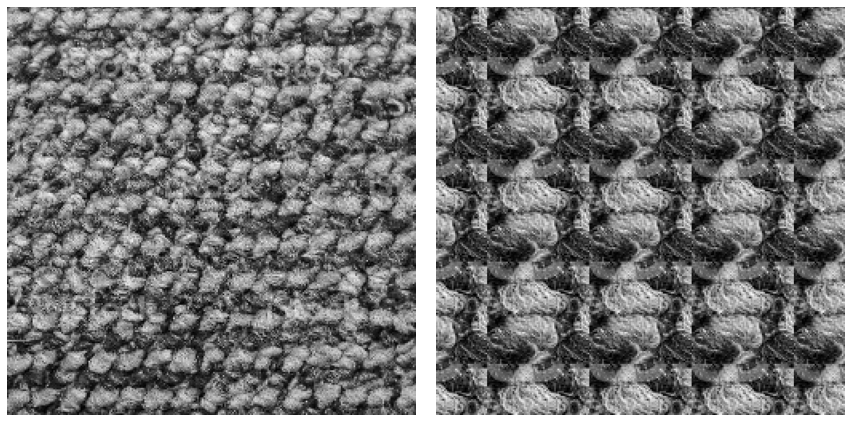

In [5]:
texture_reference_wrap = decoders.decode_image_with_patch("/content/drive/My Drive/Final_Project_RuiZhou/AdditionalTextures/Carpet.jpg", patch_size=64, target_size = SIZE)
texture_reference = decoders.decode_image("/content/drive/My Drive/Final_Project_RuiZhou/AdditionalTextures/Carpet.jpg", SIZE)

fig ,(ax1,ax2) = plt.subplots(1, 2,figsize=(15,15))
ax1.imshow(texture_reference[0,:,:,:])
ax2.imshow(texture_reference_wrap[0,:,:,:])
ax1.axis('off')
ax2.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0)


# VGG layers used for the loss
layers = ['block1_conv1',
          'block1_conv2',
          'block2_conv1',
          'block2_conv2',
          'block3_conv1', 
          'block3_conv2',
          'block3_conv3',
          'block3_conv4',
          'block4_conv1', 
          'block4_conv2',
          'block4_conv3',
          'block4_conv4',
          'block5_conv1',
          'block5_conv2'
          ]

slice_extractor = ExtractorVggModel(layers)
vgg_layers_extractor = vgg_layers(layers)

**Texture Synthesis With Sliced Wasserstein Loss**

In this experiment we compare the results of texture synthesis using SWD as the loss function on 1. The original input texture and 2. A patch of the input texture with wrap padding to the desired output.

iter 1 loss [0.02721441]
iter 2 loss [0.01457597]
iter 3 loss [0.01200929]
iter 4 loss [0.01098136]
iter 5 loss [0.01035818]
iter 6 loss [0.00961531]
iter 7 loss [0.00939519]
iter 8 loss [0.00919336]
iter 9 loss [0.00880241]
iter 10 loss [0.00869283]
iter 1 loss [0.17201072]
iter 2 loss [0.11879433]
iter 3 loss [0.09635399]
iter 4 loss [0.08514388]
iter 5 loss [0.07882624]
iter 6 loss [0.07223086]
iter 7 loss [0.06890003]
iter 8 loss [0.06754243]
iter 9 loss [0.0642476]
iter 10 loss [0.06236628]


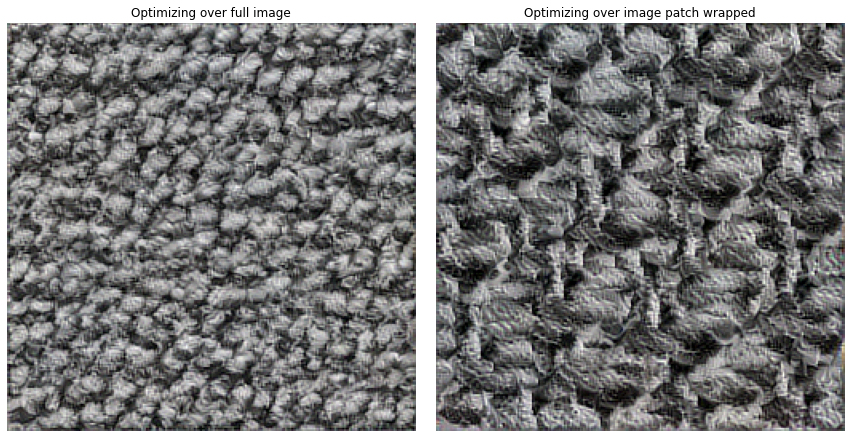

In [6]:
NB_ITER = 10
def loss_and_grad_slice(image, *args):
    """ Return loss and grad for a step. Called by lbfgs optimize  """
    image_tf = tf.constant(np.reshape(image, (1,SIZE,SIZE,3)), dtype='float32')
    args = args[0]
    extractor = args['extractor']
    targets = args['targets']

    with tf.GradientTape() as tape:
        tape.watch(image_tf) 
        outputs = extractor(image_tf)
        #L2 between the sorted slices (generated image vs target texture)
        losses =[tf.reduce_mean((output-targets[i])**2) 
                           for i, output in enumerate(outputs)]
        loss = tf.add_n(losses)
    
    grad_raw = tape.gradient(loss, image_tf)    
    grad = np.reshape(grad_raw.numpy(), (SIZE*SIZE*3,))
    loss = np.reshape(loss.numpy(), (1))  

    return loss.astype('float64'), grad.astype('float64')

def fit_slice(nb_iter, texture, extractor, feature_layers = None):
    targets = extractor(texture)
    image = initialize_image(SIZE, texture)
    losses_gram = []
    losses_slice = []
    for i in range(nb_iter):
      arg_opt = {'extractor': extractor, 'targets':targets}
      image, loss, info = fmin_l_bfgs_b(func=loss_and_grad_slice, args=[arg_opt], x0=image, maxfun=64, pgtol=0.0, factr=0.0)
      image = np.clip(image, 0, 1)
      print(f'iter {i+1} loss {loss}')
    
      # Change random directions (optional)
      extractor.update_slices()
      targets = extractor(texture)

      # compare current gram loss with sw loss
      image = np.reshape(image, (1,SIZE, SIZE, 3))
      loss1 = gram_loss(image, texture, feature_layers)
      loss2 = slice_loss(image, texture, extractor)
      losses_gram.append(loss1)
      losses_slice.append(loss2)
            
    return image,losses_gram,losses_slice

output_image,out_gram_losses,out_slice_losses = fit_slice(NB_ITER, texture_reference, slice_extractor, vgg_layers_extractor)
output_image_wrap,out_gram_losses_wrap,out_slice_losses_wrap = fit_slice(NB_ITER, texture_reference_wrap, slice_extractor, vgg_layers_extractor)

fig ,(ax1,ax2) = plt.subplots(1, 2,figsize=(15,15))
ax1.imshow(output_image[0,:,:,:])
ax2.imshow(output_image_wrap[0,:,:,:])
ax1.axis('off')
ax1.set_title('Optimizing over full image')
ax2.axis('off')
ax2.set_title('Optimizing over image patch wrapped')
plt.subplots_adjust(wspace=0.05, hspace=0)

**Comparing Loss when training on SWD**

This experiment displays that although the synthesis was trained using SWD, the gram matrix loss also converged as a by product.

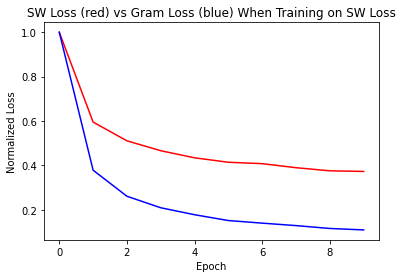

In [7]:
TS_gram_plot = np.array(out_gram_losses)
TS_slice_plot = np.array(out_slice_losses)

plt.plot(TS_slice_plot/TS_slice_plot[0],'r')
plt.plot(TS_gram_plot/TS_gram_plot[0],'b')
plt.xlabel("Epoch")
plt.ylabel("Normalized Loss")
plt.xticks(np.arange(0,NB_ITER,2))
plt.title("SW Loss (red) vs Gram Loss (blue) When Training on SW Loss")
plt.show()

**Texture Synthesis With Gram Matrix Loss**

In this experiment we compare the results of texture synthesis using Gram matrix loss as the loss function on the same two inputs as before.

iter 1 loss [0.01110195]
iter 2 loss [0.0037369]
iter 3 loss [0.0022726]
iter 4 loss [0.00165398]
iter 5 loss [0.00135269]
iter 6 loss [0.00115941]
iter 7 loss [0.00103051]
iter 8 loss [0.00094036]
iter 9 loss [0.0008692]
iter 10 loss [0.00081459]
iter 1 loss [0.12739557]
iter 2 loss [0.05484299]
iter 3 loss [0.03617406]
iter 4 loss [0.02821174]
iter 5 loss [0.02364219]
iter 6 loss [0.02041583]
iter 7 loss [0.0183563]
iter 8 loss [0.01665559]
iter 9 loss [0.01532743]
iter 10 loss [0.01426384]


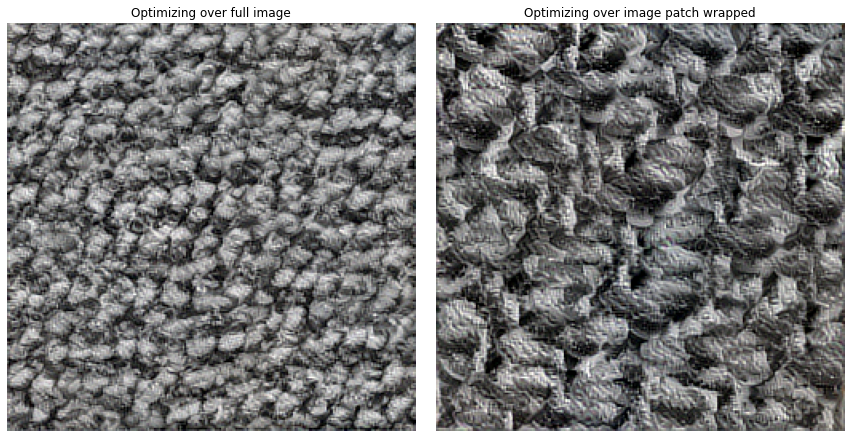

In [8]:
def loss_and_grad_gram(image, *args):
    """ Return loss and grad for a step. Called by lbfgs optimize  """
    image_tf = tf.constant(np.reshape(image, (1,SIZE,SIZE,3)), dtype='float32')
    args = args[0]
    targets = args['targets']
    extractor = args['extractor']
    gram_target = [gram_matrix(feature) for feature in targets]

    with tf.GradientTape() as tape:
        tape.watch(image_tf) 
        gram_image = [gram_matrix(feature) for feature in extractor(image_tf)]
        #L2 between the sorted slices (generated image vs target texture)
        loss = tf.add_n([tf.reduce_mean((gram_image[idx]-gram_target[idx])**2) for idx,_ in enumerate(gram_image)])
    
    grad_raw = tape.gradient(loss, image_tf)    
    grad = np.reshape(grad_raw.numpy(), (SIZE*SIZE*3,))
    loss = np.reshape(loss.numpy(), (1))  

    return loss.astype('float64'), grad.astype('float64')

def fit_gram(nb_iter, texture, extractor, feature_layers):
    targets = feature_layers(texture)
    image = initialize_image(SIZE, texture)
    losses_gram = []
    losses_slice = []
    for i in range(nb_iter):
        arg_opt = {'extractor': feature_layers, 'targets':targets}

        image, loss, info = fmin_l_bfgs_b(func=loss_and_grad_gram, args=[arg_opt], x0=image, maxfun=64, pgtol=0.0, factr=0.0)
        image = np.clip(image, 0, 1)
        print(f'iter {i+1} loss {loss}')

        # compare current gram loss with sw loss
        image = np.reshape(image, (1,SIZE, SIZE, 3)).astype('float32')
        loss1 = gram_loss(image, texture, feature_layers)
        loss2 = slice_loss(image, texture, extractor)
        losses_gram.append(loss1)
        losses_slice.append(loss2)
            
    return image,losses_gram,losses_slice

output_gram, out_gram_losses, out_slice_losses  = fit_gram(NB_ITER, texture_reference, slice_extractor, vgg_layers_extractor)
output_gram_wrap, out_gram_losses_wrap, out_slice_losses_wrap = fit_gram(NB_ITER, texture_reference_wrap, slice_extractor, vgg_layers_extractor)

fig ,(ax1,ax2) = plt.subplots(1, 2,figsize=(15,15))
ax1.imshow(output_gram[0,:,:,:])
ax2.imshow(output_gram_wrap[0,:,:,:])
ax1.axis('off')
ax1.set_title('Optimizing over full image')
ax2.axis('off')
ax2.set_title('Optimizing over image patch wrapped')
plt.subplots_adjust(wspace=0.05, hspace=0)

**Adam Optimizer**

In this experiment we test replacing the LBFGS optimzer with the adam optimizer in tensorflow.

In [9]:
extractor = vgg_layers(layers)
slice_extractor = ExtractorVggModel(layers)

optimizer = tf.optimizers.Adam(learning_rate=2, beta_1=0.99, epsilon=1e-1)
image = initialize_image(256, texture_reference)

def train_step_gram(image):
  with tf.GradientTape() as tape:
    loss = gram_loss(image, texture_reference, extractor)
  grad = tape.gradient(loss, image)
  optimizer.apply_gradients([(grad, image)])
  image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))
  return loss

def train_step_slice(image):
  with tf.GradientTape() as tape:
    loss = slice_loss(image, texture_reference, slice_extractor)
  grad = tape.gradient(loss, image)
  optimizer.apply_gradients([(grad, image)])
  image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))
  return loss

The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(1, 256, 256, 3) dtype=float32, numpy=
array([[[[0.44434002, 0.42997152, 0.4476465 ],
         [0.4376228 , 0.4365159 , 0.44673344],
         [0.4601436 , 0.45173675, 0.44069818],
         ...,
         [0.45733085, 0.4367799 , 0.42887226],
         [0.4525892 , 0.46128735, 0.4510065 ],
         [0.42348465, 0.44137776, 0.46037087]],

        [[0.45184752, 0.43367732, 0.44241905],
         [0.4509683 , 0.43636662, 0.44696045],
         [0.45002177, 0.44305038, 0.45297763],
         ...,
         [0.44882998, 0.46261337, 0.44536272],
         [0.44963014, 0.43626824, 0.46660522],
         [0.42990208, 0.45204946, 0.45511848]],

        [[0.4453813 , 0.45372117, 0.46239692],
         [0.4402806 , 0.45513308, 0.44764635],
         [0.45543995, 0.43976098, 0.43962052],
         ...,
         [0.44015083, 0.4457682 , 0.45136377],
         [0.4370798

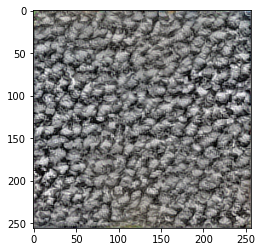

In [10]:
image_var = tf.Variable(image)
loss = []
iter = 5000
for i in range(iter):
  cur_loss = train_step_gram(image_var)
  loss.append(cur_loss)
  if i % 100 is 0:
    print(f'iter {i+1} loss {cur_loss}')

plt.imshow(image_var[0,:,:,:])